# Duke ML Project - Sparse Array DL
## Title: Data Preprocessing Notebook
## Author: Anthony DiSpirito III
## Github: @axd465

### Import Statements

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import os
import shutil
import imageio
import scipy
from functools import partial

GPU = 0
GPU_MEM = None#40960 # in Mb
use_mixed_prec = False

physical_gpus = tf.config.list_physical_devices('GPU')

if physical_gpus:
    try:
        # Disable GPU
        if GPU is None:
            gpu_id = []
        else:
            gpu_id = physical_gpus[GPU:GPU+1]
        tf.config.set_visible_devices(gpu_id, 'GPU')
        visible_gpus = tf.config.get_visible_devices('GPU')
        tf.config.experimental.set_memory_growth(*visible_gpus, True)
        print("Num Visible Physical GPUs: ", len(physical_gpus),
              "\nNum Visible GPUs Available: ", len(visible_gpus))
        if GPU is not None and GPU_MEM is not None:
            tf.config.set_logical_device_configuration(
                gpu_id[0],
                [tf.config.LogicalDeviceConfiguration(memory_limit=GPU_MEM)]
            )
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(visible_gpus), "Visible GPUs,", len(logical_gpus), "Logical GPUs")
        print(f"Visible Devices are: {tf.config.get_visible_devices()}")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

%matplotlib inline
%load_ext autoreload
%autoreload 2
print('Tensorflow version: ' + tf.__version__)

# For Mixed Precision
from tensorflow.keras import mixed_precision
if use_mixed_prec:
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print('Compute dtype: %s' % policy.compute_dtype)
    print('Variable dtype: %s' % policy.variable_dtype)

Num Visible Physical GPUs:  1 
Num Visible GPUs Available:  1
1 Visible GPUs, 1 Logical GPUs
Visible Devices are: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow version: 2.11.0


## Load data

In [2]:
from python.utils.vol_process_utils import import_mat

sparse_mat_dict = import_mat("./recon_code/pa_code/sparse_matrix.mat")
rfdata_dict = import_mat("./recon_code/pa_code/test_rfdata.mat")

In [3]:
sparse_mat_dict.keys()

dict_keys(['Cols', 'Rows', 'arr_size', 'data', 'interp_scale', 'mat_file_version'])

In [4]:
rfdata_dict.keys()

dict_keys(['__header__', '__version__', '__globals__', 'interp_scale', 'rfdata', 'mat_file_version'])

In [5]:
rfdata = np.array(rfdata_dict["rfdata"], dtype=np.float32)
new_size = [rfdata.shape[0]*sparse_mat_dict["interp_scale"][0, 0],
            rfdata.shape[1]*sparse_mat_dict["interp_scale"][1, 0]]
new_size = np.array(new_size, dtype=np.int32)
print(new_size)
rfdata = np.squeeze(tf.image.resize(rfdata[..., tf.newaxis], size=new_size))

[7680  256]


In [6]:
rfdata.shape

(7680, 256)

In [624]:
import cupy as cp
from cupyx.scipy.sparse import csr_matrix as csr_gpu
from cupyx.scipy.sparse import csc_matrix as csc_gpu
from scipy.sparse import csr_array, csc_array

indices = np.zeros([sparse_mat_dict["Cols"].shape[-1], 2], dtype=np.uint32)
indices[:, 0] = np.array(sparse_mat_dict["Rows"], dtype=np.uint32) - 1
indices[:, 1] = np.array(sparse_mat_dict["Cols"], dtype=np.uint32) - 1
values = np.array(sparse_mat_dict["data"], dtype=np.float16).flatten()
dense_shape = np.array(sparse_mat_dict["arr_size"], dtype=np.uint32).flatten()

In [789]:
def gpu_matmul(M_gpu, x_gpu):
    out = M_gpu.dot(x_gpu)
    # out = cp.flip(out)
    # out = cp.matmul(M_gpu, x_gpu)
    return out

## Test Fully Sampled sparse MatMul Recon

In [790]:
rfdata_flat = rfdata.T.flatten()[..., tf.newaxis]
print(rfdata_flat.shape)

(1966080, 1)


In [792]:
M = csc_array((values, (indices[:, 0], indices[:, 1])), shape=dense_shape) #(scipy.sparse.csr_matrix)

In [793]:
x = np.array(rfdata_flat, dtype=np.float16)  #(numpy.ndarray)

In [794]:
M.shape

(2496688, 1966080)

In [795]:
x.shape

(1966080, 1)

In [796]:
M_gpu = csc_gpu(M)
x_gpu = cp.array(x)

In [899]:
out = gpu_matmul(M_gpu, x_gpu)
out = out.get()
print(out.shape)
out_shape = (134, 137, 136)#(134, 137, 136)
p0_recon = tf.transpose(tf.reshape(out, out_shape))
p0_recon = np.array(p0_recon, dtype=np.float32)
p0_recon = p0_recon
# p0_recon = np.fliplr(p0_recon)
# p0_recon = np.flipud(p0_recon)

(2496688, 1)


In [900]:
p0_recon.shape

(136, 137, 134)

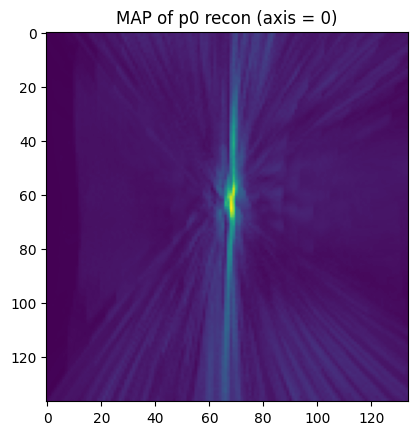

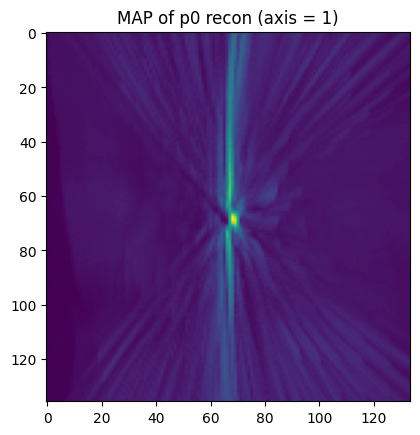

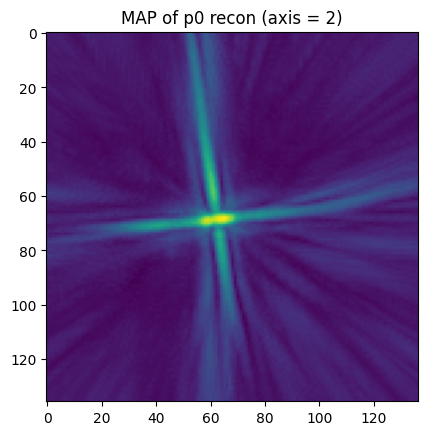

In [903]:
for i in range(len(p0_recon.shape)):
    map_axis = i
    map_img = tf.math.reduce_max(p0_recon, axis=map_axis)
    plt.imshow(map_img)
    plt.title(f"MAP of p0 recon (axis = {map_axis})")
    # plt.axis("off")
    plt.show()

## Test Undersampled Sparse MatMul Recon

In [915]:
down_ratio = 4
rfdata_down = np.zeros(rfdata.shape)
rfdata_down[:, ::down_ratio] = rfdata[:, ::down_ratio]

In [916]:
rfdata_flat = rfdata_down.T.flatten()[..., tf.newaxis]
print(rfdata_flat.shape)

(1966080, 1)


In [917]:
M = csc_array((values, (indices[:, 0], indices[:, 1])), shape=dense_shape) #(scipy.sparse.csr_matrix)

In [918]:
x = np.array(rfdata_flat, dtype=np.float16)  #(numpy.ndarray)

In [919]:
M.shape

(2496688, 1966080)

In [920]:
x.shape

(1966080, 1)

In [921]:
M_gpu = csc_gpu(M)
x_gpu = cp.array(x)

In [922]:
out = gpu_matmul(M_gpu, x_gpu)
out = out.get()
print(out.shape)
out_shape = (134, 137, 136)#(134, 137, 136)
p0_recon = tf.transpose(tf.reshape(out, out_shape))
p0_recon = np.array(p0_recon, dtype=np.float32)
p0_recon = p0_recon
# p0_recon = np.fliplr(p0_recon)
# p0_recon = np.flipud(p0_recon)

(2496688, 1)


In [923]:
p0_recon.shape

(136, 137, 134)

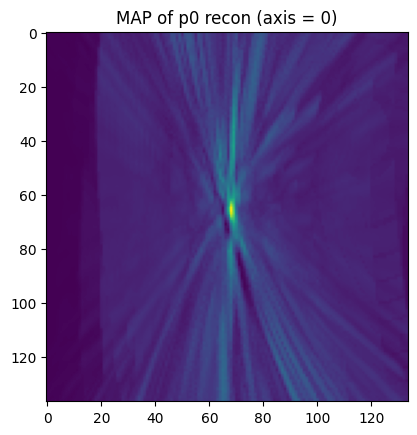

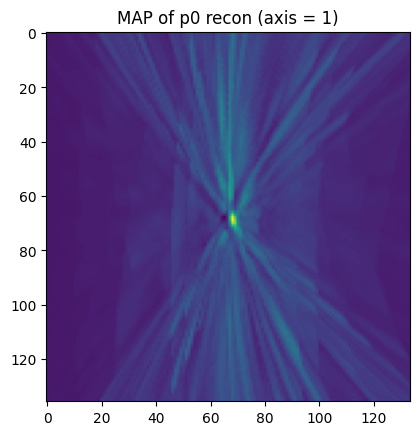

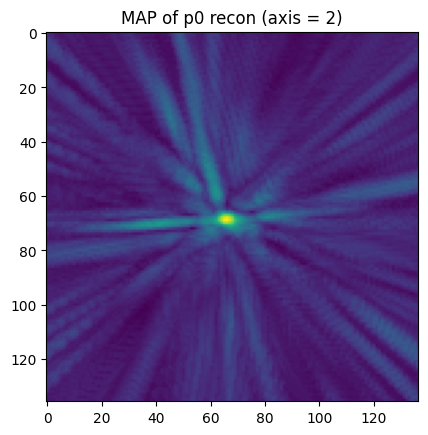

In [924]:
axis_map = {136: "X-dim",
            137: "Y-dim",
            134: "Z-dim"}
for i in range(len(p0_recon.shape)):
    map_axis = i
    map_img = tf.math.reduce_max(p0_recon, axis=map_axis)
    plt.imshow(map_img)
    plt.title(f"MAP of p0 recon (axis = {map_axis})")
    # plt.axis("off")
    plt.ylabel(f"Axis Shape = {map_img.shape[0]}, {axis_map[map_img.shape[0]]}")
    plt.xlabel(f"Axis Shape = {map_img.shape[1]}, {axis_map[map_img.shape[1]]}")
    plt.show()